In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
from scipy.optimize import curve_fit


In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams["figure.figsize"] = [5.4,4.2]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True
})

In [3]:
def psd(pathFolders, windows = 10, factor=1, channel='ch1'):
    data = []
    for file in os.listdir(pathFolders):
        if file.endswith('.pkl'):
            filePath = os.path.join(pathFolders,file)
            data.append(pd.read_pickle(filePath))            
    dt = data[0].t[1]-data[0].t[0]
    f = 1/dt
    freq, power = signal.welch(data[0][channel]*factor, f, window = 'hamming', nperseg = int(len(data[0][channel])/windows))
    for i in range(1,len(data)):
        freq, powerTemp = signal.welch(data[i][channel]*factor, f, window = 'hamming', nperseg = int(len(data[i][channel])/windows))
        power += powerTemp/np.sqrt((2*np.pi))
    power = power/len(data)
    return freq,power

In [4]:
def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base

In [5]:
def fit_psd(folder, windows=20):
    freq, power = psd(folder, windows=windows, factor=1/(11*1.504e4))
    p0 =  [396360.1039417023, 79000.0, 314284.2758744481, 0]
    ans,cov = curve_fit(lorentzian, freq, power, p0=p0, absolute_sigma=True, maxfev=10000)
    fitted_power = lorentzian(freq, *ans)
    return power, fitted_power, freq, ans

In [6]:
def convert_gains(gain, bits_decimal = 8):
    '''
    Function to convert gain values from integer representation of multiples of 
    the ADC resolution to float
    '''
    resolution = 2**-8
    return -32+(gain-8192)*resolution if gain >=8192 else  gain*resolution

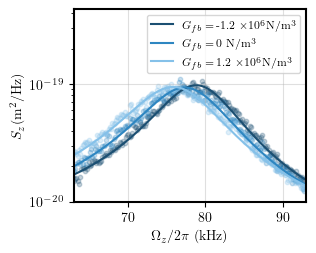

In [7]:
rootFolder = "../data/traces/batch_7"
windows = 10
gains = ['5052','0', '11332']
ax = plt.gca()
ax.figure.set_size_inches(3, 2.5, forward=True)
ax.grid(alpha = 0.4)
colors = ['#1B4F72', '#2E86C1', '#85C1E9']
labels = [r'$G_{fb}=\,$', r'$G_{fb} =\,$', r'$G_{fb}=\,$']
factors = [0.8768, 1, 0.86]
for gain, color, label, factor in zip(gains, colors, labels, factors):
    power, fitted_power, freq, _ = fit_psd('{}/{}'.format(rootFolder, gain), windows=40)
    float_gain = convert_gains(int(gain))
    float_gain = np.round(11.27*3.03e-15*np.power(-11*1.504e4*float_gain,3)/1e6, 1)
    if gain != '0':
        ax.plot(freq/1000, fitted_power/factor, color=color, label=label+str(float_gain)+r' $\times 10^6\textrm{N/m}{}^3$')
    else:
        ax.plot(freq/1000, fitted_power/factor, color=color, label=label+'0'+r' $\textrm{N/m}{}^3$') 
    ax.scatter(freq/1000, power/factor, color=color, alpha=0.25, s=10, label='_{}'.format(label))
    ax.set_xlim([63, 93])
    ax.set_ylim([10**-20, 5*max(power)])
    ax.set_yscale('log')
    ax.set(ylabel=r'$S_z(\textrm{m}{}^2$/Hz)')
    ax.set(xlabel=r'$\Omega_z/2\pi$ (kHz)')
ax.legend(fontsize=8)
plt.savefig('../plots/psd_shifts.pdf', bbox_inches='tight')
plt.show()